<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.7
IPython 7.13.0

numpy 1.18.1
scipy 1.4.1
pandas 1.0.3
matplotlib 3.1.3
statsmodels 0.11.1
sklearn 0.22.1

compiler   : GCC 7.3.0
system     : Linux
release    : 5.4.48-gentoo-x86_64
machine    : x86_64
processor  : Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz
CPU cores  : 8
interpreter: 64bit
Git hash   :


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [12]:
cv_score = cross_val_score(estimator=knn, X=X_train.todense(), y=y_train, cv=skf).mean()

In [13]:
knn.fit(X=X_train.todense(), y=y_train)
y_pred = knn.predict(X=X_valid.todense())
knn_score = accuracy_score(y_true=y_valid, y_pred=y_pred)

In [14]:
ans = f'{np.round(cv_score, 3)} {np.round(knn_score, 3)}'
ans

'0.563 0.587'

In [15]:
with open('answer4_1.txt', 'w') as file:
    file.write(ans)

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, n_jobs=-1, oob_score=True)

In [18]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=17, verbose=0,
                       warm_start=False)

In [19]:
oob = forest.oob_score_
oob

0.7238366185734607

In [20]:
y_pred = forest.predict(X_valid)
val_score = accuracy_score(y_true=y_valid, y_pred=y_pred)

In [21]:
ans = f'{np.round(oob, 3)} {np.round(val_score, 3)}'
ans

'0.724 0.731'

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [22]:
with open('answer4_2.txt', 'w') as file:
    file.write(ans)

In [23]:
!cat answer4_2.txt

0.724 0.731

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [24]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [25]:
logit = LogisticRegression(random_state=17, n_jobs=-1)

In [26]:
cv_score = cross_val_score(estimator=logit, X=X_train, y=y_train, cv=skf).mean()

In [27]:
logit.fit(X=X_train, y=y_train)
y_pred = logit.predict(X=X_valid)
val_score = accuracy_score(y_true=y_valid, y_pred=y_pred)

In [28]:
ans = f'{np.round(cv_score, 3)} {np.round(val_score, 3)}'
ans

'0.761 0.777'

In [29]:
with open('answer4_3.txt', 'w') as file:
    file.write(ans)

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [30]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

# logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, cv=skf, random_state=17, n_jobs=-1, multi_class='multinomial')
logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, cv=skf, multi_class='multinomial', random_state=17)
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 1min 7s, sys: 898 ms, total: 1min 8s
Wall time: 17.1 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='multinomial',
                     n_jobs=None, penalty='l2', random_state=17, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [31]:
scores1 = [logit_grid_searcher1.scores_[i][j] 
           for i in logit_grid_searcher1.scores_
           for j in range(len(logit_grid_searcher1.scores_[i]))]
logit_mean_cv_scores1 = np.asarray(scores1).mean(axis=0)

In [32]:
logit_mean_cv_scores1

array([0.31954964, 0.47307397, 0.55202236, 0.64875035, 0.71438846,
       0.75177962, 0.76102545, 0.75879029, 0.74944244, 0.74131409])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [33]:
max_score = max(logit_mean_cv_scores1)
max_score

0.7610254470801336

In [34]:
logit_grid_searcher1.Cs_[logit_mean_cv_scores1.argmax()]

1.0

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

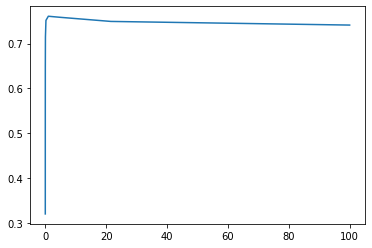

In [35]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [36]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, cv=skf, multi_class='multinomial', random_state=17)
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 3min 46s, sys: 3.29 s, total: 3min 49s
Wall time: 57.5 s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='multinomial',
                     n_jobs=None, penalty='l2', random_state=17, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [37]:
scores2 = [logit_grid_searcher2.scores_[i][j] 
           for i in logit_grid_searcher2.scores_
           for j in range(len(logit_grid_searcher2.scores_[i]))]
logit_mean_cv_scores2 = np.asarray(scores2).mean(axis=0)
logit_mean_cv_scores2

array([0.73481117, 0.75939974, 0.7612287 , 0.76072057, 0.76102539,
       0.76153355, 0.76000937, 0.75939971, 0.75970453, 0.75919655,
       0.75919661, 0.75848539, 0.75787581, 0.75736787, 0.75716462,
       0.75604698, 0.75523422, 0.75482781, 0.75401499, 0.7532021 ])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [38]:
max_score = max(logit_mean_cv_scores2)
max_score

0.7615335461873364

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

In [39]:
logit_grid_searcher2.Cs_[logit_mean_cv_scores2.argmax()]

1.9157894736842107

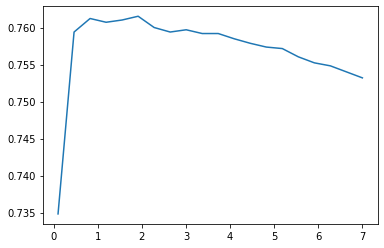

In [40]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [41]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
logit_cv_acc

0.7790945721735009

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [42]:
ans = str(round((np.max(logit_mean_cv_scores2)), 3)) + ' ' + str(round(logit_cv_acc, 3))
ans

'0.762 0.779'

In [43]:
with open('answer4_4.txt', 'w') as file:
    file.write(ans)

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [44]:
from sklearn.svm import LinearSVC

In [45]:
svm = LinearSVC(C=1, random_state=17)

In [46]:
cv_score = cross_val_score(estimator=svm, X=X_train, y=y_train, cv=skf).mean()

In [47]:
svm.fit(X=X_train, y=y_train)
y_pred = svm.predict(X=X_valid)
val_score = accuracy_score(y_true=y_valid, y_pred=y_pred)

In [48]:
ans = f'{np.round(cv_score, 3)} {np.round(val_score, 3)}'
print(ans)
# with open('answer4_5.txt', 'w') as file:
#     file.write(ans)

0.751 0.777


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [49]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, cv=skf, return_train_score=True)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 49.3 s, sys: 985 µs, total: 49.3 s
Wall time: 49.4 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             error_score=nan,
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [50]:
svm_grid_searcher1.best_score_

0.6868546856376824

In [51]:
svm_grid_searcher1.best_params_

{'C': 2222.2223000000004}

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

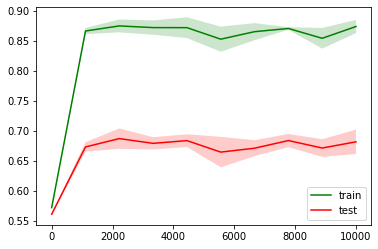

In [52]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [53]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, cv=skf, return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 1min 28s, sys: 31.1 ms, total: 1min 28s
Wall time: 1min 28s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             error_score=nan,
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.001     , 0.035448...
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=Non

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [54]:
svm_grid_searcher2.best_score_

0.7670206386611259

In [55]:
svm_grid_searcher2.best_params_

{'C': 0.10434482758620689}

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

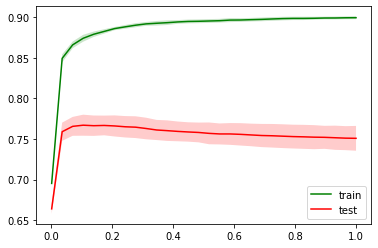

In [56]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [57]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))
svm_cv_acc

0.7807537331121118

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [58]:
ans = str(round(svm_grid_searcher2.best_score_, 3)) + ' ' + str(round(svm_cv_acc, 3))

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [60]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    with open(path_to_X_pickle, 'rb') as file:
        X = pickle.load(file)
    with open(path_to_y_pickle, 'rb') as file:
        y = pickle.load(file)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=test_size, 
                                                     random_state=17, stratify=y)
    estimator.fit(X_train, y_train)
    
    return cross_val_score(estimator, X_train, y_train, cv=cv).mean(), accuracy_score(y_valid, estimator.predict(X_valid))

**Убедитесь, что функция работает.**

In [61]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7670206386611259, 0.7807537331121118)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [62]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [63]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_' + str(session_length) + '_' + str(window_size) + '.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_' + str(session_length) + '_' + str(window_size) + '.pkl')
        print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3))

(0.8187357674018679, 0.839535434937189)
(0.7670206386611259, 0.7807537331121118)
(0.8471561308551244, 0.8579724572755931)
(0.7980806025863226, 0.8035506885681102)
(0.749644899761945, 0.7607433217189314)
(0.8656132938787092, 0.8795637743006164)
(0.8149070542488689, 0.8315552394499763)
(0.7695356848115806, 0.7876955903271693)
(0.7211157439935167, 0.7393314366998578)
CPU times: user 39.4 s, sys: 36.9 ms, total: 39.5 s
Wall time: 39.8 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [64]:
cv_score, accuracy = model_assessment(svm_grid_searcher2.best_estimator_, 
                                     os.path.join(PATH_TO_DATA, 'X_sparse_10users_15_5.pkl'),
                                     os.path.join(PATH_TO_DATA, 'y_10users_15_5.pkl'),
                                     skf, random_state=17, test_size=0.3)

In [65]:
cv_score, accuracy

(0.8656132938787092, 0.8795637743006164)

In [66]:
ans = str(round(cv_score, 3)) + ' ' + str(round(accuracy, 3))

In [67]:
with open('answer4_5.txt', 'w') as file:
    file.write(ans)

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [68]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users_' + str(session_length) + '_' + str(window_size) + '.pkl')
    path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users_' + str(session_length) + '_' + str(window_size) + '.pkl')
    print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3))

(0.4100454192283424, 0.420560179101572)
(0.43814508240996214, 0.4509656981299179)
(0.46307591254574465, 0.4836276942538802)
CPU times: user 17min 8s, sys: 764 ms, total: 17min 9s
Wall time: 17min 12s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [69]:
cv_score, accuracy = model_assessment(svm_grid_searcher2.best_estimator_, 
                                     os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'),
                                     os.path.join(PATH_TO_DATA, 'y_150users.pkl'),
                                     skf, random_state=17, test_size=0.3)

In [70]:
print(cv_score, accuracy)

0.46307591254574465 0.4836276942538802


In [72]:
ans = str(round(cv_score, 3)) + ' ' + str(round(accuracy, 3))
ans

'0.463 0.484'

In [73]:
with open('answer4_6.txt', 'w') as file:
    file.write(ans)

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [74]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [75]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [76]:
%%time
Cs = [float(svm_grid_searcher2.best_params_['C'])]
logit_cv_150users = LogisticRegressionCV(Cs=Cs, cv=skf, random_state=17, multi_class='ovr', n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 14min 47s, sys: 11.7 s, total: 14min 59s
Wall time: 3min 45s


LogisticRegressionCV(Cs=[0.10434482758620689], class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='ovr',
                     n_jobs=None, penalty='l2', random_state=17, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [99]:
list(logit_cv_150users.scores_.values())[0]

array([[0.99521441],
       [0.99577742],
       [0.99499546]])

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [101]:
# cv_scores_by_user = {}
# for user_id in logit_cv_150users.scores_:
#     print('User {}, CV score: {}'.format(user_id, cv_scores_by_user[user_id].mean()))
    
# cv_scores_by_user = list(logit_cv_150users.scores_.values())
for user_id, score in logit_cv_150users.scores_.items():
    print('User {}, CV score: {}'.format(user_id, score.mean()))

User 6, CV score: 0.9953291003305079
User 13, CV score: 0.9958816844431934
User 15, CV score: 0.9948390729098245
User 16, CV score: 0.9910960975050306
User 28, CV score: 0.9892611012063015
User 31, CV score: 0.994422028296477
User 33, CV score: 0.9932334511484365
User 39, CV score: 0.9852470468028317
User 46, CV score: 0.997591567357918
User 49, CV score: 0.9943490454891412
User 50, CV score: 0.9942760626818054
User 53, CV score: 0.9933168600711061
User 65, CV score: 0.996924295976562
User 66, CV score: 0.9949746124091625
User 82, CV score: 0.9963091551718746
User 85, CV score: 0.9962674507105399
User 89, CV score: 0.9902411560476683
User 92, CV score: 0.9941405231824675
User 100, CV score: 0.9947660901024887
User 102, CV score: 0.990814592391021
User 103, CV score: 0.9783345323365967
User 105, CV score: 0.996423842440545
User 106, CV score: 0.9936922002231189
User 118, CV score: 0.9900534859716618
User 119, CV score: 0.9962465984798724
User 120, CV score: 0.9939320008757937
User 126, 

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [117]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = []

for user_id in np.unique(y_train_150):
    val = (class_distr.sum() - class_distr[user_id])/class_distr.sum()
    print(val)
    acc_diff_vs_constant.append(logit_cv_150users.scores_[user_id].mean() - val)
    print("User: {},  difference: {}".format(user_id, logit_cv_150users.scores_[user_id].mean() - val))

0.984402531460803
User: 6,  difference: 0.010926568869704889
0.9957044404825206
User: 13,  difference: 0.00017724396067275716
0.9944011760658097
User: 15,  difference: 0.0004378968440148512
0.9847153149208137
User: 16,  difference: 0.006380782584216926
0.9879474106742568
User: 28,  difference: 0.0013136905320446646
0.9944533066424781
User: 31,  difference: -3.12783460011401e-05
0.9925453275364132
User: 33,  difference: 0.0006881236120233059
0.9839125040401197
User: 39,  difference: 0.0013345427627120543
0.9971223921679022
User: 46,  difference: 0.00046917519001576924
0.9938277397224569
User: 49,  difference: 0.0005213057666842991
0.9941509492978011
User: 50,  difference: 0.00012511338400422733
0.9920448740003962
User: 53,  difference: 0.0012719860707098851
0.9969242959765621
User: 65,  difference: -1.1102230246251565e-16
0.9948599251404919
User: 66,  difference: 0.00011468726867058798
0.9963508596332092
User: 82,  difference: -4.170446133466843e-05
0.996194467903204
User: 85,  differen

In [189]:
num_better_than_default = (np.array(acc_diff_vs_constant) > 0.).sum()
num_better_than_default

130

In [190]:
len(acc_diff_vs_constant)

150

In [147]:
ans = str(round(num_better_than_default/ len(acc_diff_vs_constant), 3))
ans

'0.807'

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [148]:
with open('answer4_7.txt', 'w') as file:
    file.write(ans)

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [94]:
y_binary_128 = [1 if i == 128 else 0 for i in y_150users]

In [95]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [125]:
from sklearn.utils import shuffle
X_shuf, Y_shuf = shuffle(X_sparse_150users, y_binary_128)

In [126]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_shuf, Y_shuf, 
                                              train_sizes=train_sizes, 
                                              cv=skf)

CPU times: user 24.1 s, sys: 3.37 ms, total: 24.1 s
Wall time: 24.2 s


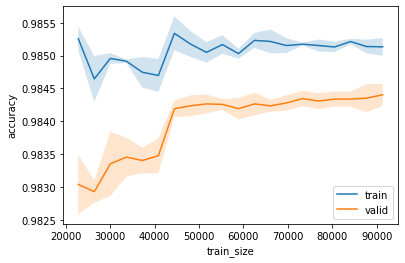

In [127]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.